In [1]:
import numpy as np
import cv2
import os
from keras.layers import Input
from model import VGG16
import matplotlib.pyplot as plt

def padding(x):
    h,w,c = x.shape
    size = max(h,w)
    paddingh = (size-h)//2
    paddingw = (size-w)//2
    temp_x = np.zeros((size,size,c))
    temp_x[paddingh:h+paddingh,paddingw:w+paddingw,:] = x
    return temp_x

def load_image(path):
    x = cv2.imread(path)
    sh = x.shape
    x = np.array(x, dtype=np.float32)
    x = x[..., ::-1]
    # Zero-center by mean pixel
    x[..., 0] -= 103.939
    x[..., 1] -= 116.779
    x[..., 2] -= 123.68
    x = padding(x)
    x = cv2.resize(x, target_size, interpolation=cv2.INTER_LINEAR)
    x = np.expand_dims(x,0)
    return x,sh

def cut(pridict,shape):
    h,w,c = shape
    size = max(h, w)
    pridict = cv2.resize(pridict, (size,size))
    paddingh = (size - h) // 2
    paddingw = (size - w) // 2
    return pridict[paddingh:h + paddingh, paddingw:w + paddingw]

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def getres(pridict,shape):
    pridict = sigmoid(pridict)*255
    pridict = np.array(pridict, dtype=np.uint8)
    pridict = np.squeeze(pridict)
    pridict = cut(pridict, shape)
    return pridict

def laplace_edge(x):
    laplace = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
    edge = cv2.filter2D(x/255.,-1,laplace)
    edge = np.maximum(np.tanh(edge),0)
    edge = edge * 255
    edge = np.array(edge, dtype=np.uint8)
    return edge

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

model_name = 'model/PFA_00050.h5'

target_size = (256,256)

dropout = False
with_CPFE = True
with_CA = True
with_SA = True

if target_size[0 ] % 32 != 0 or target_size[1] % 32 != 0:
    raise ValueError('Image height and wight must be a multiple of 32')

model_input = Input(shape=(target_size[0],target_size[1],3))
model = VGG16(model_input,dropout=dropout, with_CPFE=with_CPFE, with_CA=with_CA, with_SA=with_SA)
model.load_weights(model_name,by_name=True)

for layer in model.layers:
    layer.trainable = False

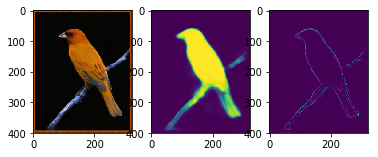

In [3]:
image_path = 'image/2.jpg'
img, shape = load_image(image_path)
img = np.array(img, dtype=np.float32)
sa = model.predict(img)
sa = getres(sa, shape)
plt.title('saliency')
plt.subplot(131)
plt.imshow(cv2.imread(image_path))
plt.subplot(132)
plt.imshow(sa)
plt.subplot(133)
edge = laplace_edge(sa)
plt.imshow(edge)
plt.show()